This notebook addresses the Home Credit Default Risk Kaggle Problem. The primary objective is to predict, with the greatest accuracy possible, whether a loan will default. To address the question presented, we evaluate a dataset with dimensions: rows - 307,522 and columns - 122. For are problem set we set a target accuracy of .65 with the ROC AUC score as our target metric. We also evaluate precision and recall, because the dataset demonstrates relatively low richness. We begin our prediction task by importing our relevant libraries.

In [1]:
# all the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import pprint
import copy
import seaborn as sns
from scipy.stats import itemfreq

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Imputer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

/Users/gauravdesai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/gauravdesai/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Notebook lavel configurations
warnings.filterwarnings('ignore')
pp = pprint.PrettyPrinter(indent=4)

In [3]:
# List input files, if not available please download from below url inot a /input.nosync folder
input_dir = 'input.nosync'
input_files = os.listdir(input_dir)
if input_files is None or len(input_files) < 10 :
    raise Exception('You do not have all the files in {} directory'.format(input_dir))

print('You have all the input files listed below')
pp.pprint(input_files)

You have all the input files listed below
[   'application_test.csv',
    '.DS_Store',
    'HomeCredit_columns_description.csv',
    'POS_CASH_balance.csv',
    'credit_card_balance.csv',
    'installments_payments.csv',
    'application_train.csv',
    'bureau.csv',
    'previous_application.csv',
    'bureau_balance.csv',
    'sample_submission.csv']


Here, we read in our primary dataset. As noted above and shown below, the dataset is of moderate size with 307,511 samples. The data is relatively wide with 122 features presented. Notably, we use the pandas library to handle reading our csv, as the data contains a mixute of numerical and categorical data. Using the pd.head() function we provide a view into the data, which demonstrate these features. It is also notable that some null/Nan values are present. We evaluated methods of handling Nan features including automatic handling/dropping and mean imputation. The presence of the Nan values did not prevent us from reaching our goal of .65 as we will see.

In [4]:
# Read application_train.csv
app_train = pd.read_csv(input_dir+'/application_train.csv')
print('Training data shape (Before Split): ', app_train.shape)
app_train.head()

Training data shape (Before Split):  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Below we allocate a training and testing split and set the random state to ensure repeatability. To accomplish this, we use the built-in train_test_split function. We reserve 20% of the data for testing, which results in training and test sets of the size printed. We also remove the target feature, and remove the ID feature because it is not pertinent to the analysis.

In [5]:
# Move Target column to seperate object
app_train_labels = app_train['TARGET']
app_train = app_train.drop('TARGET', axis=1)

# split the training dataset into training (80%) and testing (20%)
split_ratio = 0.20
app_train_data, app_test_data, train_labels, test_labels = train_test_split(
    app_train, app_train_labels, test_size = split_ratio, random_state = 23 )

# Move SK_ID_CURR to different object so that it does not interfer with classifier
app_train_data_skid_curr = app_train_data['SK_ID_CURR']
#app_train_data = app_train_data.drop('SK_ID_CURR', axis=1)
app_test_data_skid_curr = app_test_data['SK_ID_CURR']
#app_test_data = app_test_data.drop('SK_ID_CURR', axis=1)

In [6]:
print('Training data shape: ', app_train_data.shape)
print('Training label shape: ', train_labels.shape)
print('Test data shape: ', app_test_data.shape)
print('Test label shape: ', test_labels.shape)

print('Training SK ID data shape: ', app_train_data_skid_curr.shape)
print('Test SK ID data shape: ', app_test_data_skid_curr.shape)

Training data shape:  (246008, 121)
Training label shape:  (246008,)
Test data shape:  (61503, 121)
Test label shape:  (61503,)
Training SK ID data shape:  (246008,)
Test SK ID data shape:  (61503,)


In [7]:
def replace_anamoly_add_indicator(data, data_column_name, anamoly_value, replacement_value=np.nan
                                  ,anamoly_column_prefix='ANOMOLY_'):
    anamoly_column_name = anamoly_column_prefix + data_column_name
    data[anamoly_column_name] = data[data_column_name] == anamoly_value
    data[data_column_name].replace({anamoly_value: replacement_value}, inplace = True)
    
    #print(data[[data_column_name,anamoly_column_name]])
    return data

In [8]:
#still lets fix it
app_train_data = replace_anamoly_add_indicator(app_train_data,'DAYS_EMPLOYED',365243)
app_test_data = replace_anamoly_add_indicator(app_test_data,'DAYS_EMPLOYED',365243)

In [9]:
#Looks like first 1000 days mean something, so lets add this variable in main training and test data set
print('Before Shape',app_train_data.shape,app_test_data.shape)
app_train_data['RECENT_DAYS_LAST_PHONE_CHANGE']=(app_train_data['DAYS_LAST_PHONE_CHANGE']*-1)<1000
app_test_data['RECENT_DAYS_LAST_PHONE_CHANGE']=(app_test_data['DAYS_LAST_PHONE_CHANGE']*-1)<1000
print('After Shape',app_train_data.shape,app_test_data.shape)


Before Shape (246008, 122) (61503, 122)
After Shape (246008, 123) (61503, 123)


In [10]:
# add EXT columns polynomials in main data
ext_columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

app_train_data_ext = pd.DataFrame(data=app_train_data, columns=ext_columns)
app_train_data_ext.fillna(0, inplace=True)
app_test_data_ext = pd.DataFrame(data=app_test_data, columns=ext_columns)
app_test_data_ext.fillna(0, inplace=True)


poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(app_train_data_ext)

app_train_data_ext=poly_transformer.transform(app_train_data_ext)
app_test_data_ext=poly_transformer.transform(app_test_data_ext)

ploy_feature_names = poly_transformer.get_feature_names(input_features = ext_columns)
print('ploy_feature_names=')
pp.pprint(ploy_feature_names)

app_train_data_ext = pd.DataFrame(app_train_data_ext, 
                             columns = ploy_feature_names)
app_test_data_ext = pd.DataFrame(app_test_data_ext, 
                             columns = ploy_feature_names)

app_train_data_ext=app_train_data_ext.assign(SK_ID_CURR=app_train_data_skid_curr.values)
app_test_data_ext=app_test_data_ext.assign(SK_ID_CURR=app_test_data_skid_curr.values)

#drop original columns otherwise while merging column name changes
app_train_data_ext=app_train_data_ext.drop(ext_columns,axis=1)
app_test_data_ext=app_test_data_ext.drop(ext_columns,axis=1)

app_train_data=pd.DataFrame(data=app_train_data)
app_test_data=pd.DataFrame(data=app_test_data)

app_train_data = app_train_data.merge(app_train_data_ext, on = 'SK_ID_CURR', how = 'left')
app_test_data = app_test_data.merge(app_test_data_ext, on = 'SK_ID_CURR', how = 'left')


ploy_feature_names=
[   '1',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'EXT_SOURCE_1^2',
    'EXT_SOURCE_1 EXT_SOURCE_2',
    'EXT_SOURCE_1 EXT_SOURCE_3',
    'EXT_SOURCE_2^2',
    'EXT_SOURCE_2 EXT_SOURCE_3',
    'EXT_SOURCE_3^2',
    'EXT_SOURCE_1^3',
    'EXT_SOURCE_1^2 EXT_SOURCE_2',
    'EXT_SOURCE_1^2 EXT_SOURCE_3',
    'EXT_SOURCE_1 EXT_SOURCE_2^2',
    'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
    'EXT_SOURCE_1 EXT_SOURCE_3^2',
    'EXT_SOURCE_2^3',
    'EXT_SOURCE_2^2 EXT_SOURCE_3',
    'EXT_SOURCE_2 EXT_SOURCE_3^2',
    'EXT_SOURCE_3^3']


Align train and test so clumns match

In [13]:
print('Training data shape: ', app_train_data.shape)
print('Test data shape: ', app_test_data.shape)

(246008, 140)
(61503, 140)


Impute missing values, using the column mean

In [14]:
# Function to calculate missing values by column 
def get_missing_values_stats(data, label):
        # Total missing values
        missing_values = data.isnull().sum()
        
        # Percentage of missing values
        missing_values_percent = 100 * missing_values / len(data)
        
        # Percentage of missing values when Target = 0
        missing_values_percent_target_0 = 100 * data[label.values==0].isnull().sum() / len(data[label.values==0])
        
        # Percentage of missing values when Target = 1
        missing_values_percent_target_1 = 100 * data[label.values==1].isnull().sum() / len(data[label.values==1])       
        
        
        # results table
        status_table = pd.concat([missing_values, missing_values_percent
                                  , missing_values_percent_target_0, missing_values_percent_target_1
                                 , abs(missing_values_percent_target_0-missing_values_percent_target_1)]
                                 , axis=1)
        
        # Give Headers
        status_table = status_table.rename(
        columns = {0 : 'Missing Count', 1 : '%Total'
                  ,2 : '%Target=0', 3 : '%Target=1'
                  ,4 : '%Diff'})
        
        
        
        # Remove columns not having any missing values
        status_table = status_table[status_table['Missing Count'] != 0]
        status_table = status_table.drop('Missing Count', axis=1)

        
        # Sort the table by percentage of missing descending
        status_table = status_table.sort_values(
        '%Diff', ascending=False)
        
        print ("Data has {} columns out of which {} columns that have missing values"
               .format(str(data.shape[1]),str(status_table.shape[0])))
        
        return status_table
    
#print(app_train_data.shape,type(app_train_data))
#print(train_labels.shape,type(train_labels))
#app_train_data[train_labels.values==0]
train_missing_values = get_missing_values_stats(app_train_data, train_labels)
print('First 30 columns with highest %Diff are\n')
print(train_missing_values.head(30))

Data has 140 columns out of which 68 columns that have missing values
First 30 columns with highest %Diff are

                                 %Total  %Target=0  %Target=1     %Diff
FLOORSMAX_AVG                 49.760577  49.140055  56.815325  7.675270
FLOORSMAX_MEDI                49.760577  49.140055  56.815325  7.675270
FLOORSMAX_MODE                49.760577  49.140055  56.815325  7.675270
EMERGENCYSTATE_MODE           47.392361  46.772717  54.437126  7.664409
ENTRANCES_MODE                50.333729  49.714973  57.368395  7.653422
ENTRANCES_MEDI                50.333729  49.714973  57.368395  7.653422
ENTRANCES_AVG                 50.333729  49.714973  57.368395  7.653422
TOTALAREA_MODE                48.263065  47.644382  55.296898  7.652516
YEARS_BEGINEXPLUATATION_MODE  48.770365  48.159155  55.719242  7.560087
YEARS_BEGINEXPLUATATION_MEDI  48.770365  48.159155  55.719242  7.560087
YEARS_BEGINEXPLUATATION_AVG   48.770365  48.159155  55.719242  7.560087
ELEVATORS_MODE           

In [15]:
print('Number of columns with more than 3% difference in number of missing values when Target is 0 vs 1 = {}'
      .format(sum(train_missing_values['%Diff'] > 3)))

Number of columns with more than 3% difference in number of missing values when Target is 0 vs 1 = 58


Out of 68 columns having missing values 58 columns have more than 3% difference between % of missing values for Target = 0 vs Target = 1
Hence this looks like significant information. So while we impute the Nulls with 0 we need to capture that these values were Null in an indicator column

In [16]:
#Change Null to 0's and add indicator column for each column having Null value
def replace_null_add_indicator(data):
    missing_values = data.isnull().sum()
    columns = list(data.columns)

    #print(missing_values)
    for i,missing_count in enumerate(missing_values):
        if missing_count > 0:
            original_column_name = columns[i]
            indicator_column_name = 'Null_Indicator_'+original_column_name 
            data[indicator_column_name] = data[original_column_name].isnull()
            data[original_column_name].fillna(value=0,inplace=True)
    
replace_null_add_indicator(app_train_data)
print('After creating indicator columns, Training Data shape={}'.format(app_train_data.shape))
print('Lets check how many columns still have NULL = {}'.format(app_train_data.isnull().sum().sum()))

After creating indicator columns, Training Data shape=(246008, 208)
Lets check how many columns still have NULL = 0


In [17]:
#Perform same operation on test data
replace_null_add_indicator(app_test_data)
print('After creating indicator columns, Training Data shape={}'.format(app_test_data.shape))
print('Lets check how many columns still have NULL = {}'.format(app_test_data.isnull().sum().sum()))

After creating indicator columns, Training Data shape=(61503, 206)
Lets check how many columns still have NULL = 0


In [18]:
app_train_data = app_train_data.drop('SK_ID_CURR', axis=1)
app_test_data = app_test_data.drop('SK_ID_CURR', axis=1)
print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

Training Features shape:  (246008, 207)
Testing Features shape:  (61503, 205)


Convert categorical columns to numeric.
We will use Label Encoding for columsn having upto 2 distinct values
And will use One Hot Encoding for other columns

In [19]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in list(app_train_data.columns):
    #print(col,app_train_data[col].dtype)
    if app_train_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train_data[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train_data[col])
            # Transform both training and testing data
            app_train_data[col] = le.transform(app_train_data[col])
            app_test_data[col] = le.transform(app_test_data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('{} columns were label encoded'.format(le_count))
print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

3 columns were label encoded
Training Features shape:  (246008, 207)
Testing Features shape:  (61503, 205)


As a first measure of data reshaping, we convert our categorical variables using one-hot encoding. For this, we again rely on pandas functionality. The process works on categorical variables and extends our datasets width to 243. features. Note that we align the data to ensure that the columns match withion the testing and training sets.

In [20]:
#use label encoding for unique values upto 2
app_train_data = pd.get_dummies(app_train_data)
app_test_data = pd.get_dummies(app_test_data)

print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

Training Features shape:  (246008, 334)
Testing Features shape:  (61503, 331)


In [21]:


app_train_data, app_test_data = app_train_data.align(app_test_data, join = 'inner', axis = 1)
print(app_train_data.shape)
print(app_test_data.shape)

(246008, 331)
(61503, 331)


As previously mentioned our data contained a number of Nan values. In some cases, like the CREDIT_BUREAU Fields and OWN_CAR_AGE fields, the numbers were significant with ~66% and %15 respectively. As an initial measure, we will impute the median value for our Nan values. We also use Min-Max scaling to regularize our data to ensure that no one feature is given to much weight in our models. We do this because we anticipate using regression methods. In addition, large features may be given too much weight in PCA, which is based on variance capture, without proper scaling.
Notably, we did attempt other feature engineering, but we did not see drastically changed results. Some efforts included using ratios of components. Dropping components after identifying the least influential by using LASSO linear regression methods, and different imputation strategies like the mean. We suspect that the lack of success with our other feature engineering efforts may be the result of a confluence of factors including the presence of Nan values and the necessity for highly specialized domain expertise.

In [22]:
imputer = Imputer(strategy = 'median')

app_train_data = imputer.fit_transform(app_train_data)
app_test_data = imputer.transform(app_test_data)
#app_train_data.fillna(0, inplace=True)
#app_test_data.fillna(0, inplace=True)

In [23]:
scaler = MinMaxScaler(feature_range = (0, 1))
app_train_data = scaler.fit_transform(app_train_data)
app_test_data = scaler.transform(app_test_data)

In [24]:
# get optimum PCA for faster execution
cover_variance = .80
def get_optimum_pca(data, cover_variance=cover_variance):
    # Start with some large PCA number to speed up the calculation
    start_pca_no = 100
    
    #increement by some small number
    change_no_by = 20
    
    #max number of iterations to avoid infinite loops
    max_iter = 10
    
    iter_counter = 1
    current_pca_no = start_pca_no
    
    while True:
        
        pca = PCA(n_components=current_pca_no)
        pca.fit(data)
        var_ratios = pca.explained_variance_ratio_
        var_ratios_cum_sum = [sum(var_ratios[:i+1]) for i in range(len(var_ratios))]
        
        print('Iteration {} explains {} variance with {} PCA components'
              .format(iter_counter, var_ratios_cum_sum[-1], current_pca_no))
        #print(var_ratios)
        #print(var_ratios_cum_sum)
        
        if var_ratios_cum_sum[-1] >= cover_variance:
            for i, ration_sum in enumerate(var_ratios_cum_sum):
                if ration_sum >= cover_variance:
                    return i+1
                    
        iter_counter = iter_counter + 1
        if iter_counter > max_iter:
            print('Did not reach targetted covariance ratio {} in {} iterations'
                  .format(cover_variance, max_iter))
            print('Current calculated PCA number {} will cover {} % variance'
                  .format(current_pca_no, var_ratios_cum_sum[-1]))
            break
            
        current_pca_no = current_pca_no + change_no_by

    return current_pca_no

pca_no = get_optimum_pca(app_train_data)
print('To cover variance of {} we will use PCA with {} components'
      .format(cover_variance,pca_no))

Iteration 1 explains 0.9815431150827928 variance with 100 PCA components
To cover variance of 0.8 we will use PCA with 21 components


In [25]:
# Reduce dimentions of training and test data using PCA
pca = PCA(n_components=pca_no)
app_train_data_pca = pca.fit_transform(app_train_data)
app_test_data_pca = pca.transform(app_test_data)

In [26]:
# After PCA lets see the shape
print(app_train_data_pca.shape)
print(app_test_data_pca.shape)

(246008, 21)
(61503, 21)


In [27]:
#This tuple will be used by all classifiers

#PCA
train_test_data_pca = {
    'train_data'   : app_train_data_pca,
    'test_data'    : app_test_data_pca,
    'train_labels' : train_labels,
    'test_labels'  : test_labels
}

#Non PCA
train_test_data_all = {
    'train_data'   : app_train_data,
    'test_data'    : app_test_data,
    'train_labels' : train_labels,
    'test_labels'  : test_labels
}

train_test_data = train_test_data_pca

We next start to build our analysis tools and crate baseline measures. As a first measure, we create the Stat_Holder class, which begins to abstract away some of our coding tasks. The Stat_holder provides information about PCA components and parameters along with our target accuracy in a human readable format

In [28]:
class Stat_Holder:
    
    def __init__(self, pca_component_no, classifier_name, classifier_params
                 , roc_auc_score, recall_score, precision_score): 
        self.pca_component_no = pca_component_no
        self.classifier_name = classifier_name
        self.classifier_params = classifier_params
        self.roc_auc_score = roc_auc_score
        self.recall_score = recall_score
        self.precision_score = precision_score
        
    def __str__(self):
        return '{pca_component_no='+ str(self.pca_component_no) +\
                ' classifier_name=' + str(self.classifier_name) +\
                ' classifier_params=' + str(self.classifier_params) +\
                ' roc_auc=' + str(self.roc_auc_score) +\
                ' recall=' + str(self.recall_score) +\
                ' precision=' + str(self.precision_score) +\
                '}'
        
    def __lt__(self, other):

        
        # sort decending by roc_auc_score
        return self.roc_auc_score > other.roc_auc_score 
# End of class Stat_Hlder   

def sort_print_stats(stats,top=10):    
    stats=sorted(stats)
    print_stats(stats,top)

def print_stats(stats,top=10):
    print('\n')
    print('{:^6}{:^12}{:^40}{:^10}{:^30}{:^10}{:^10}'
          .format('Sr. No.','No. of PCA','Classifier','ROC AUC','Classifier Params', 'Recall', 'Precision'))
    print('_'*118)
    for index,stat in enumerate(stats[:top]):
        print('{:^6}{:^12}{:^40}{:>10.5}{:^30}{:>10.5}{:>10.5}'
              .format(index+1,stat.pca_component_no,stat.classifier_name
                      ,stat.roc_auc_score,stat.classifier_params,stat.recall_score,stat.precision_score))

Now lets use various combinations of PCA and Random Forest to get baseline predictions

The next layer of abstraction provides is obtained through a number of funtions, which performs our PCA transformations and fits and runs our classifiers. Here, we use a PCA count of 1 through 5 and use 4 different classifiers. We also vary the hyperparameters of our models for several different mixes within these ranges. The classifiers used included: Decision tree, Kmeans, Gaussian, and KNN.

In [29]:
def get_estimater_name(clf):
    if type(clf).__name__ == 'GridSearchCV':
        estimater_name = 'GridSearchCV:'+ type(clf.estimator).__name__
    else:
        estimater_name = type(clf).__name__
    return estimater_name

def get_estimater_param(clf,clf_params):
    if type(clf).__name__ == 'GridSearchCV':
        for i,param in enumerate(clf_params.split(',')):
            if i > 0:
                parameters = parameters + ','
            parameters = param + '=' + str(clf.best_params_[param])    
    else:
        parameters = clf_params

    return parameters

def run_classifier(clf, train_data,train_labels,test_data,test_labels,pca_no,clf_params):
    positive_probability_threashold = .06 #.09 calculated
    '''
    print('Train Data Shape',train_data.shape)
    print('Train Label Shape',train_labels.shape)
    print('Test Data Shape',test_data.shape)
    print('Test Label Shape',test_labels.shape)
    '''
    clf = clf.fit(train_data,train_labels)
    
    test_labels_proba = clf.predict_proba(test_data)
    print('Test Labels Predicted Probability Shape', test_labels_proba.shape)
    test_labels_predicted = test_labels_proba[:,-1] > positive_probability_threashold
    test_labels_predicted.astype(int)
    
    #test_labels_predicted = clf.predict(test_data)
    '''
    print('Train Labels unique values',np.unique(train_labels))
    print('Test Labels unique values',np.unique(test_labels))
    print('Test Labels predicted unique values',np.unique(test_labels_predicted))
    '''
    
    roc_auc_score = metrics.roc_auc_score(test_labels,test_labels_predicted)
    recall_score = metrics.recall_score(test_labels,test_labels_predicted)
    precision_score = metrics.precision_score(test_labels,test_labels_predicted)
   
    st = Stat_Holder(pca_no,get_estimater_name(clf),get_estimater_param(clf,clf_params)
                     ,roc_auc_score,recall_score,precision_score)
    return st

def run_classifiers(min_PCA, max_PCA, classifier_list, train_test_data = train_test_data):
    stats = []
    
    train_data = train_test_data['train_data'][:limit_data,]
    train_labels = train_test_data['train_labels'][:limit_data,]
    test_data = train_test_data['test_data'][:limit_data]
    test_labels = train_test_data['test_labels'][:limit_data]
    
    #print(train_data.shape)
    #print(train_labels.shape)
    #print(test_data.shape)
    #print(test_labels.shape)
    
    for classifier in classifier_list:
        clf = classifier.get('clf')
        clf_params = classifier.get('params')
        print('{} started with params {}'.format(get_estimater_name(clf),clf_params))
        #print(clf)
        
        #print(clf_params)
        if min_PCA is None:
            st = run_classifier(clf, train_data,train_labels
                                        ,test_data,test_labels
                                ,'NA',clf_params)
            print(st)
            stats.append(st)
        else:
            pca_range = range(min_PCA,max_PCA+1)
            for pca_no in pca_range:
                    print('\tPCA {} started'.format(pca_no), end=" ")
                    pca = PCA(n_components = pca_no,copy = True)
                    train_data_pca = pca.fit_transform(train_data) 
                    test_data_pca = pca.transform(test_data) 

                    st = run_classifier(clf, train_data_pca,train_labels
                                        ,test_data_pca,test_labels
                                        ,pca_no,clf_params)
                    stats.append(st)
                    print('\tPCA {} completed'.format(pca_no))
                    #print_stats([st])
        print('{} completed'.format(get_estimater_name(clf)))
    return stats
    


In [30]:
all_stats=[] #stats across all algo, never overridden
stats = [] #stats for specific group, overridden for each group

minPCA = 1
maxPCA = 5
limit_data = None
classifiers = []
classifiers.append({'clf':DecisionTreeClassifier(max_depth=5), 'params':'max_depth=5'} )
classifiers.append({'clf':KMeans(n_clusters=5), 'params':'n_clusters=5'} )
classifiers.append({'clf':GaussianMixture(n_components=3), 'params':'n_components=3'} )
classifiers.append({'clf':KNeighborsClassifier(n_neighbors=3), 'params':'n_neighbors=3'} )
#classifiers
#stats=run_classifiers(minPCA,maxPCA,classifiers)
#all_stats.extend(stats)

After processing, we exmaine our top classifiers based on our ROC_AUC accuracy measure. Our top perfomers achieved our target accuracy metric of .65. Interestingly, although we met our metric and tested several different models, the data does not provide an especially high level of accuracy. Below we will examine some alternative methods and use different measures to attempt to analyze and augment our results.

In [31]:
sort_print_stats(stats,top=15)



Sr. No. No. of PCA                Classifier                ROC AUC        Classifier Params         Recall  Precision 
______________________________________________________________________________________________________________________


Again we utilize our abstraction process and shift our attention to Logistic Regression, Gradient Boosting, and Random Forest Classifiers. After evaulation, we do not see a change to our top performer.

In [32]:
limit_data = None
classifiers = []
classifiers.append({'clf':LogisticRegression(C = 0.1), 'params':'C = 0.1'} )
classifiers.append({'clf':LogisticRegression(C = 0.01), 'params':'C = 0.01'} )
classifiers.append({'clf':LogisticRegression(C = 0.001, n_jobs=-1), 'params':'C = 0.001'} )
classifiers.append({'clf':LogisticRegression(C = 0.0001), 'params':'C = 0.0001'} )
#classifiers.append({'clf':RandomForestClassifier(n_estimators = 50), 'params':'n_estimators = 50'} )
#classifiers.append({'clf':RandomForestClassifier(n_estimators = 100, n_jobs=1), 'params':'n_estimators = 100'} )
#classifiers.append({'clf':GradientBoostingClassifier(n_estimators = 20,max_depth=7,verbose=True), 'params':'n_estimators = 100'} )
#classifiers.append({'clf':GradientBoostingClassifier(n_estimators = 50,max_depth=4,verbose=True), 'params':'n_estimators = 100'} )


stats=run_classifiers(None,None,classifiers)
all_stats.extend(stats)
sort_print_stats(stats)

LogisticRegression started with params C = 0.1
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=LogisticRegression classifier_params=C = 0.1 roc_auc=0.6493957327721328 recall=0.8109805510534847 precision=0.12139131489568171}
LogisticRegression completed
LogisticRegression started with params C = 0.01
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=LogisticRegression classifier_params=C = 0.01 roc_auc=0.6478998517098196 recall=0.8223257698541329 precision=0.11993617587093343}
LogisticRegression completed
LogisticRegression started with params C = 0.001
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=LogisticRegression classifier_params=C = 0.001 roc_auc=0.6189006974675461 recall=0.8897893030794165 precision=0.1064133937440942}
LogisticRegression completed
LogisticRegression started with params C = 0.0001
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_

In [35]:
# Summary of top 15 execution. 
sort_print_stats(all_stats,top=15)



Sr. No. No. of PCA                Classifier                ROC AUC        Classifier Params         Recall  Precision 
______________________________________________________________________________________________________________________
  1        NA                LogisticRegression               0.6494           C = 0.1               0.81098   0.12139
  2        NA                LogisticRegression               0.6479           C = 0.01              0.82233   0.11994
  3        NA                LogisticRegression               0.6189          C = 0.001              0.88979   0.10641
  4        NA                LogisticRegression              0.50009          C = 0.0001                 1.0  0.080269


In [36]:
limit_data = None
clusters = {'n_clusters':list(range(8,10))}
depths = {'max_depth':list(range(5,7))}
components = {'n_components':list(range(5,6))}
neighbors = {'n_neighbors':list(range(5,6))}
#Cs = {'C':[.1,.01,.001,.0001]}
#estimators = {'n_estimators':[50,100,150]}

Cs = {'C':[.001]}
estimators = {'n_estimators':[50]}

classifiers = []
classifiers.append({'clf':GridSearchCV(estimator=KMeans(), param_grid=clusters), 'params':'n_clusters'} )
classifiers.append({'clf':GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=depths), 'params':'max_depth'} )
classifiers.append({'clf':GridSearchCV(estimator=GaussianMixture(verbose=1), param_grid=components), 'params':'n_components'} )
classifiers.append({'clf':GridSearchCV(estimator=KNeighborsClassifier(), param_grid=neighbors), 'params':'n_neighbors'})
classifiers.append({'clf':GridSearchCV(estimator=LogisticRegression(), param_grid=Cs), 'params':'C'} )
classifiers.append({'clf':GridSearchCV(estimator=RandomForestClassifier(), param_grid=estimators), 'params':'n_estimators'} )
classifiers.append({'clf':GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=estimators), 'params':'n_estimators'} )

#stats=run_classifiers(None,None,classifiers)
#all_stats.extend(stats) 
#sort_print_stats(stats)

In our final configurations, we see that our best model is our GradientBoostingClassifier, which allows us to achieve our target.

In [37]:
# Summary of top 15 execution. 
sort_print_stats(all_stats,top=15)



Sr. No. No. of PCA                Classifier                ROC AUC        Classifier Params         Recall  Precision 
______________________________________________________________________________________________________________________
  1        NA                LogisticRegression               0.6494           C = 0.1               0.81098   0.12139
  2        NA                LogisticRegression               0.6479           C = 0.01              0.82233   0.11994
  3        NA                LogisticRegression               0.6189          C = 0.001              0.88979   0.10641
  4        NA                LogisticRegression              0.50009          C = 0.0001                 1.0  0.080269


In the code block below, we explore some alternative methods of prediction and explore the alternative metrics of precision and recall. The method of prediction provided by the Acorn class is to aggregate the 'votes' of several classifers and find a consensus on the ultimate classification of the target feature. Notably, we use 3 or 5 classifiers to avoid tie votes. The theory behind this method is that the aggregation of predictions is likely to be more accurate than any single prediction. This principle has been demonstrated in prediction markets as well as with mathematical examples.
To test the point, we selected some of our lower performing classifers. The results below are interesting in that we obtain a relatively high precision and recall score with both being in the low 90s. In addition, we obtain a a ROC AUC score of .63, which is very close to our original target using three underperforming classifiers.

In [38]:
class Acorn():

    def __init__(self, classifiers, X):
        self.classifiers = classifiers
        self.votes = [clf.predict(X) for clf in self.classifiers]
        self.election_results = None

    def _get_votes(self):
        # 3 and 5 clasifiers to avoid ties
        if len(self.votes) == 3:
            return np.c_[self.votes[0], self.votes[1], self.votes[2]]
        if len(self.votes) == 5:
            return np.c_[self.votes[0], self.votes[1], self.votes[2], self.votes[3], self.votes[4]]
        else:
            print('number of classiefiers must be 3 or 5')

    def vote(self):
        vote_pool = self._get_votes()
        self.election_results = np.array([np.argmax(np.bincount(item)) for item in vote_pool])
        return self.election_results
    
    def spf_score(self, y, average='micro'):
        if np.shape(self.election_results) == np.shape(y):
            print('election_results counts: 0=',sum(self.election_results==0),'1=',sum(self.election_results==1))
            print('Score: {}\n'.format(np.sum(self.election_results == y)/np.shape(self.election_results)[0]))
            print('Precision:{} | Recall: {} | ROC_AUC: {}\n'
                  .format(metrics.precision_score(y, self.election_results, average=average),
                          metrics.recall_score(y, self.election_results, average=average),
                          metrics.roc_auc_score(y, self.election_results, average=average)
                         ))
            #print('F1 score: {}'.format(f1_score(y, self.election_results)))
    
    def roc_it(self, X, y, plot=False):
        p = np.array(None)
        d = 0
        for i, clf in enumerate(self.classifiers):
            if i == 0:
                p = clf.predict_proba(X)
            else:
                p = p + clf.predict_proba(X)
                d = i
        prob_pos = p/(d+1)
        prob_pos = np.array([prob_pos[i,x] for i, x in enumerate(np.argmax(prob_pos, axis=1))])
        
        #code adapted from matplotlib
        if plot == True:
            fpr, tpr, _ = metrics.roc_curve(y, prob_pos)
            roc_auc = metrics.auc(tpr, fpr)
            plt.plot(tpr, fpr, color='orange',
                    lw=1.5, label='ROC Curve (area = %0.2f)' % roc_auc)
            plt.plot([0,1], [0,1], color='steelblue', lw=1, linestyle='--')
            plt.xlim([0.0,1.0])
            plt.ylim([0.0,1.0])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc='lower right')
            plt.show()
        else:
            print('ROC_AUC score: {}'.format(metrics.roc_auc_score(y, prob_pos)))
        return p/(d+1)

In [39]:
pca = PCA(n_components = 5,copy = True)
train_data_pca = pca.fit_transform(app_train_data) 
test_data_pca = pca.transform(app_test_data) 
    

In [40]:
logreg = classifiers[4]['clf']
#logreg.fit(app_train_data, train_labels)
logreg.fit(train_data_pca , train_labels)
randtree = classifiers[5]['clf']
#randtree.fit(app_train_data, train_labels)
randtree.fit(train_data_pca , train_labels)
grad = classifiers[6]['clf']
#grad.fit(app_train_data, train_labels)
grad.fit(train_data_pca , train_labels)
   
#classifiers

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

election_results counts: 0= 61503 1= 0
Score: 0.9197437523372843

Precision:0.9197437523372843 | Recall: 0.9197437523372843 | ROC_AUC: 0.5



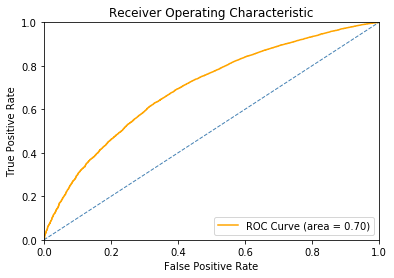

array([[0.93034222, 0.06965778],
       [0.95399302, 0.04600698],
       [0.83993043, 0.16006957],
       ...,
       [0.8373083 , 0.1626917 ],
       [0.93532907, 0.06467093],
       [0.90687556, 0.09312444]])

In [41]:
acorn = Acorn([logreg, randtree, grad],test_data_pca)
acorn.vote()
acorn.spf_score(test_labels)
acorn.roc_it(test_data_pca, test_labels, plot=True)

In the code and notes above, we demonstrated a process that hit our target accuracy metric. To accomplish, this we made some attempts at featuring engineering, but ultimately chose to reduce the dimenisonality after the feature engineering efforts were largely ineffective. We believe that this is due to the need for domain expertise to engineer additional features. As a result, we used PCA to reduce the dimensionality of our data and utilize only those features which captured the greatest amount of variance in our data. This technique proved effective and allowed us to achieve our goal of accuracy. Finally, we examined an alternative/experimental method of classification which aggregates the predictions of several classifiers to made a prediction. This method had interesting results in that the consensus prediction of three under-performing classifiers very nearly allowed us to achieve our accuracy goal without adjustment to our models.